<a href="https://colab.research.google.com/github/fdavenport/CIVE480A6-climate-change-impacts/blob/main/lectures/06_Analyzing_Extreme_Events.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIVE 480A6: Climate Change Risks and Impacts
## Week 9: Analyzing Extreme Events

This week's Objectives:
1. Analyze the distribution of daily maximum temperature.
2. Calculate percentiles of the temperature distribution.
3. Calculate how often daily temperatures exceed certain thresholds.
4. Calculate "block maxima" (in this case, the hottest day of the year).
5. Learn how to fit a Generalized Extreme Value (GEV) distribution to the time series of block maxima.

## Part 1: Daily Temperature Data

Today we will be looking at daily temperature data. We will again be using data from the [Global Historical climatology Network (GHCN-D)](https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-daily).  

We will be looking specifically at data from a weather station near Atlanta, Georgia. The data file contains the high and low (maximum and minimum) temperatures for each day.

<img src="https://raw.githubusercontent.com/fdavenport/CIVE480A6-climate-change-impacts/main/lectures/img/atlanta_map.png" width="400">
<img src="https://raw.githubusercontent.com/fdavenport/CIVE480A6-climate-change-impacts/main/lectures/img/heatwave.jpg" width="300">

In [1]:
# The data has already been added to the course github page at the following link:

atl_temp_data_url = "https://raw.githubusercontent.com/fdavenport/CIVE480A6-climate-change-impacts/refs/heads/main/lectures/data/USW00013874_atlanta_temp.csv"


In [2]:
# we are working with tabular data in a .csv file, so we need to import the pandas library

import pandas as pd

In [3]:
# read in the data

atl_data = pd.read_csv(atl_temp_data_url)

In [4]:
# look at the data

atl_data

,DATE,TMAX_degC,TMIN_degC
0,1940-01-01,1.7,-7.2
1,1940-01-02,-0.6,-9.4
2,1940-01-03,2.8,-8.9
3,1940-01-04,5.6,-5.6
4,1940-01-05,3.9,-3.3
...,...,...,...
30310,2022-12-27,11.1,-1.0
30311,2022-12-28,14.4,-1.0
30312,2022-12-29,18.9,5.6
30313,2022-12-30,19.4,8.3


We see that the table contains daily data beginning in 1940 and ended in 2022. There are two variable columns that correspond to the high (max) and low (min) temperature on each day.

In [5]:
# convert DATE column to datetime format so that we can add year and month information

atl_data["DATE"] = pd.to_datetime(atl_data["DATE"])
atl_data["year"] = atl_data["DATE"].dt.year
atl_data["month"] = atl_data["DATE"].dt.month

atl_data.set_index("DATE", inplace=True)

atl_data


,TMAX_degC,TMIN_degC,year,month
DATE,,,,
1940-01-01,1.7,-7.2,1940,1
1940-01-02,-0.6,-9.4,1940,1
1940-01-03,2.8,-8.9,1940,1
1940-01-04,5.6,-5.6,1940,1
1940-01-05,3.9,-3.3,1940,1
...,...,...,...,...
2022-12-27,11.1,-1.0,2022,12
2022-12-28,14.4,-1.0,2022,12
2022-12-29,18.9,5.6,2022,12


In [6]:
# get a summary of the data


atl_data.describe()

,TMAX_degC,TMIN_degC,year,month
count,30315.000000,30315.000000,30315.000000,30315.000000
mean,22.272053,11.470912,1981.000627,6.522778
std,8.537343,8.480547,23.958183,3.448769
min,-9.400000,-22.200000,1940.000000,1.000000
25%,16.100000,4.400000,1960.000000,4.000000
50%,23.300000,12.200000,1981.000000,7.000000
75%,29.400000,19.400000,2002.000000,10.000000
max,41.100000,27.800000,2022.000000,12.000000


In [7]:
# import matplotlib.pyplot to make graphs


import matplotlib.pyplot as plt


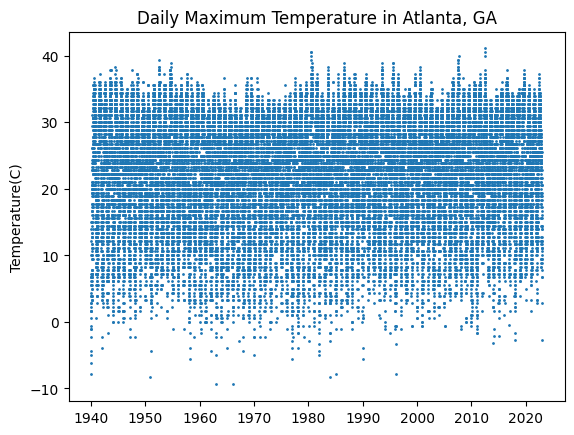

In [10]:
# make a plot of the data


fig, ax = plt.subplots()

ax.scatter(x = atl_data.index, y = atl_data["TMAX_degC"], s = 1)
ax.set_title("Daily Maximum Temperature in Atlanta, GA")
ax.set_ylabel("Temperature(C)");



We see that there is a large spread in daily maximum temperature in Atlanta, with daily high temperatures ranging anywhere from -10C on the coldest days to 40C on the very hottest days.

It's hard to tell whether there are trends in the data, but it does appear that there haven't been as many extremely cold days since ~2000.

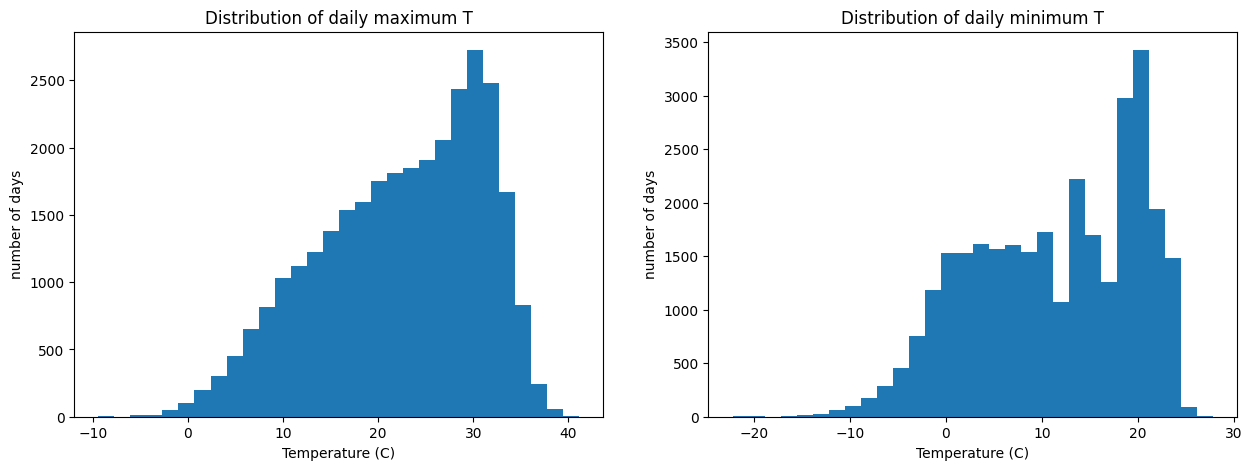

In [17]:
# create a histogram of the daily temperature data


fig, axes = plt.subplots(1, 2, figsize = (15, 5))


axes[0].hist(x = atl_data["TMAX_degC"], bins = 30);
axes[0].set_title("Distribution of daily maximum T")
axes[0].set_xlabel("Temperature (C)")
axes[0].set_ylabel("number of days");

axes[1].hist(x = atl_data["TMIN_degC"], bins = 30);
axes[1].set_title("Distribution of daily minimum T")
axes[1].set_xlabel("Temperature (C)")
axes[1].set_ylabel("number of days");

## Part 2: Calculating percentiles and exceedences

In this section, we are going to look at the 95th percentile minimum and maximum temperature within the summer months (June, July, and August) in Atlanta, GA. This will give us a sense for what a rare or "extreme" hot temperature would look like at this particular location.

Oftentimes, we use percentiles to define extremes, because what is extreme in one place might not be extreme in another location. For example, 100 F is very extreme in Alaska, but not so extreme in Phoenix, AZ.

First let's look at daily maximum summer temperatures in Atlanta:

In [18]:
## subset the data for summer months

summer_data = atl_data.loc[atl_data["month"].isin([6, 7, 8])]

summer_data


,TMAX_degC,TMIN_degC,year,month
DATE,,,,
1940-06-01,27.8,15.6,1940,6
1940-06-02,28.9,15.6,1940,6
1940-06-03,30.6,15.0,1940,6
1940-06-04,30.6,17.2,1940,6
1940-06-05,32.2,18.9,1940,6
...,...,...,...,...
2022-08-27,32.2,22.8,2022,8
2022-08-28,31.7,22.8,2022,8
2022-08-29,32.2,22.8,2022,8


We will use the [quantile()](https://numpy.org/doc/2.0/reference/generated/numpy.quantile.html) function from the numpy package to calculate the 95th percentile

In [19]:
# import numpy

import numpy as np


In [41]:
# for the np.quantile function,
# the first argument is our data, the second argument is the quantile (aka percentile) that we want to calculate

# calculate the 95th percentile of TMAX for all summer days:

TMAX_p95 = np.quantile(summer_data["TMAX_degC"], q = 0.95)

TMAX_p95

35.6

In [42]:
## conver to Fahrenheit

TMAX_p95*9/5+32

96.08000000000001

This tells us that about 5% of summer days in Atlanta have temperatures above 96.08 F.

How many days have maximum temperatures above the 95th percentile? To answer this, we will compare the temperature on each day to our 95th percentile threshold to see if the value is greater than or equal to the threshold. We will first do this for the first 10 values from our table to see how this works:  

In [43]:
# print out the first 10 rows of our table

summer_data.iloc[0:10]

,TMAX_degC,TMIN_degC,year,month
DATE,,,,
1940-06-01,27.8,15.6,1940,6
1940-06-02,28.9,15.6,1940,6
1940-06-03,30.6,15.0,1940,6
1940-06-04,30.6,17.2,1940,6
1940-06-05,32.2,18.9,1940,6
1940-06-06,35.6,19.4,1940,6
1940-06-07,35.6,20.6,1940,6
1940-06-08,33.3,20.6,1940,6
1940-06-09,30.0,18.3,1940,6


In [47]:
## compare these 10 values for
summer_data.iloc[1:10]["TMAX_degC"] >= TMAX_p95

,TMAX_degC
DATE,
1940-06-02,False
1940-06-03,False
1940-06-04,False
1940-06-05,False
1940-06-06,True
1940-06-07,True
1940-06-08,False
1940-06-09,False
1940-06-10,False


Python returns "False" if the temperature is lower than TMAX_p95, and "True" if the temperature is greater than TMAX_p95.

Conveniently, Python equates "True" with a value of 1, and "False" with a value of 0. If we take the sum of the True and False data, the total sum will be equal to the number of True cases.

In [48]:
sum(summer_data.iloc[1:10]["TMAX_degC"] >= TMAX_p95)

2

This tells us that there were two True cases within the first 10 rows. If we repeat this for all of the summer data, we will know the total number of days with temperatures greater than or equal to TMAX_p95:

In [50]:
sum(summer_data["TMAX_degC"] >= TMAX_p95)


456

There are 456 days with temperatures >= 35.6 C.

In [33]:
## get the total number of rows (aka days) in our data

len(summer_data)

7636

In [51]:
## calculate percentage of days with T > TMAX_p95

456/7636*100

5.971712938711367

5.97% of days have temperatures above TMAX_p95. This isn't exactly 5% because it turns out there are a lot of duplicate values in the data. Quite a few days have temperatures of exactly 35.6 C.

We can use the same function to calculate different percentiles:

In [52]:
# the 99th percentile of maximum daily temperature
np.quantile(summer_data["TMAX_degC"], q = 0.99)

37.2

In [37]:
# convert to Fahrenheit

37.2*9/5+32

98.96000000000001

In [38]:
# the 1st percentile of minimum daily summer temperature
# in other words, only 1% of summer days have temperatures below this value

np.quantile(summer_data["TMIN_degC"], q = 0.01)

13.9

In [39]:
# convert to F

13.9*9/5+32

57.02

## Part 3: Calculating changes in the frequency of extreme cold and extreme hot days

Let's calculate the frequency of extreme hot days over time to see if it has changed:

In [ ]:
## how many days are there with maximum temperatures above the 95th percentile in each year?
## Hint: let's use our code from previous lectures to loop through all of the years



In [ ]:
## make a time series plot:



To practice, let's apply the same analysis to daily minimum temperatures. Daily minimum temperatures are an especially important metric to understand the human health consequences of heat waves. If it stays very warm at night, people are unable to cool down and sustained hot temperatures are more likely to cause negative health impacts.

In [ ]:
## calculate the 95th percentile of daily minimum temperature for summer months (June, July, and August)



In [ ]:
## how many days have minimum temperatures above this threshold in each year?



In [ ]:
## add this to our figure



What are some other ways we could assess changes in the intensity or frequency of extreme hot events?

## Part 4: Using Extreme Value statistics to analyze very rare temperature events

In this section, we will use extreme value statistics to estimate the probability of very rare extreme events, including those that may be more rare than anything in the historical data.

Recall from class, that extreme value theory applies to "block maxima", or the maximum value in each block of time. For this case, we will consider each calendar year as a block of time. This means we need to calculate the maximum temperature value within each year.

Secondly, recall from class that one of the assumptions of extreme value theory is that our data is "stationary", meaning that our data is not changing over time because of some external factor (such as climate change!). Clearly, our data is changing over time!

For the purposes of this exercise, we will analyze data from the most recent 30-year period. While there are still changes over this period, these changes will be smaller than those over the entire period, so this will get us closer to stationary conditions.

In [ ]:
## calculate annual maxima for the period from 1994 through 2023



The Fisher–Tippett–Gnedenko theorem tells us that the distribution of block maxima can be described by the Generalized Extreme Value (GEV) distribution.

The GEV distribution is described by three parameters (location, scale, and shape) and the following equation:


GEV plot:

Just like we can calculate mean and standard deviation for a sample dataset, we can figure out the location, scale, and shape parameters that best match our data.

We will use the [genextreme()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.genextreme.html#scipy.stats.genextreme) function from the scipy package to calculate the GEV parameters for our data.  

In [ ]:
## load genextreme() function



In [ ]:
## fit our data



In [ ]:
## make a graph of a GEV distribution with these parameters



In [ ]:
## what is the magnitude of a 10-year event? a 20-year event? a 100-year event?



In [ ]:
## what is the uncertainty range for a 10-year event? what about a 100-year event?



In [ ]:
## make a Quantile-Quantile plot



In [ ]:
## make a Return Period plot

